# Directional detection in WIMpy_NREFT

First we'll load `WIMpy` and a bunch of other libraries:

In [25]:
from WIMpy import DMUtils as DMU

#This is a fudge so that the notebook reads the version of WIMpy
#in my local folder, rather than the pip-installed one...
#import sys
#sys.path.append("../WIMpy/")

#import DMUtils as DMU

#We'll also import some useful libraries
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({'font.size': 18,'font.family':'serif'})
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rc('text', usetex=True)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

from tqdm import tqdm

from scipy.interpolate import interp1d

-----------

### The Radon Transform

The Radon transform $\hat{f}(v_\mathrm{min}, \cos\theta, \phi)$ is the equivalent of the velocity integral in non-directional detection. More information can be found at [hep-ph/0209110](https://arxiv.org/abs/hep-ph/0209110).

Here, $\cos\theta, \phi$ is the direction of the recoiling nucleus.

In the function `calcRT`, the direction of the recoiling nucleus is measured from the mean recoil direction (essentially anti-parallel to the Earth's motion). So $\theta = 0$ is along is th mean recoil direction. This means that the Radon Transform only depends on $\theta$, not $\phi$.

In [26]:
v_list = np.linspace(0, 801,1000)
theta_list = np.linspace(0, np.pi, 101)

v_grid, theta_grid = np.meshgrid(v_list, theta_list)

RT_grid = DMU.calcRT(v_grid, theta_grid)


Now let's plot it:

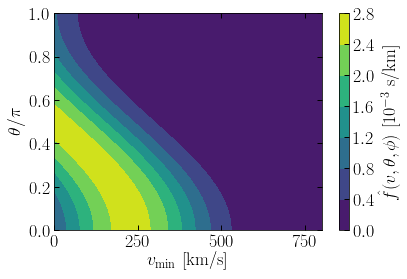

In [27]:
plt.figure()

plt.contourf(v_grid, theta_grid/np.pi, 1e3*RT_grid)

plt.xlabel(r'$v_\mathrm{min}$ [km/s]')
plt.ylabel(r'$\theta/\pi$')

plt.colorbar(label=r'$\hat{f}(v,\theta,\phi)$ [$10^{-3}$ s/km]')

plt.show()

And again, in polar coordinates:

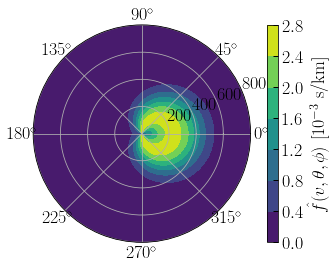

In [28]:
plt.figure()
ax = plt.subplot(111, projection='polar')

c = ax.contourf( theta_grid,v_grid, 1e3*RT_grid)
ax.contourf(np.pi+theta_grid[::-1],v_grid, 1e3*RT_grid) #Plot twice to get both sides of the polar plot...

#plt.xlabel(r'$v_\mathrm{min}$ [km/s]')
#plt.ylabel(r'$\theta/\pi$')
plt.colorbar(c,label=r'$\hat{f}(v,\theta,\phi)$ [$10^{-3}$ s/km]')

plt.show()

Now let's check that the Radon Transform is correctly normalised. By definition, if we integrate over all recoil directions, we should get the velocity integral:

$$ \eta \left( v _ { \min } \right) = \int _ { v _ { \min } } ^ { \infty } \frac { f ( \mathbf { v } ) } { v } \mathrm { d } ^ { 3 } \mathbf { v } = \frac{1}{2\pi}\oint \hat { f } \left( v _ { \min } , \hat { \mathbf { q } } \right) \mathrm { d } \Omega _ { q }$$

Note that the integral over $\phi$ in this case contributes the factor of $2\pi$.

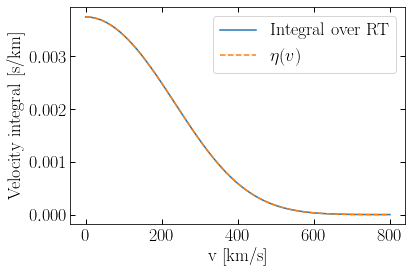

In [29]:
integral = 2*np.pi*np.trapz(np.sin(theta_grid)*RT_grid, theta_grid, axis=0)

plt.figure()

plt.plot(v_list, integral/(2*np.pi), label='Integral over RT')

plt.plot(v_list, DMU.calcEta(v_list), linestyle='--', label='$\eta(v)$')

plt.xlabel('v [km/s]')
plt.ylabel('Velocity integral [s/km]')

plt.legend()

plt.show()

--------

### The Modified Radon Transform

When the cross section depends on $v^2$, we need to calculate what I'm calling the the *modified* Radon Transform. See e.g. [arXiv:1505.07406](https://arxiv.org/abs/1505.07406) or [arXiv:1505.06441](https://arxiv.org/abs/1505.06441).

In [30]:
v_list = np.linspace(0, 801,1000)
theta_list = np.linspace(0, np.pi,1001)

v_grid, theta_grid = np.meshgrid(v_list, theta_list)

MRT_grid = DMU.calcMRT(v_grid, theta_grid)

Now let's plot it:

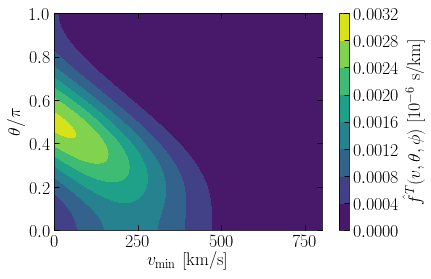

In [31]:
plt.figure()

plt.contourf(v_grid, theta_grid/np.pi, 1e6*MRT_grid)

plt.xlabel(r'$v_\mathrm{min}$ [km/s]')
plt.ylabel(r'$\theta/\pi$')

plt.colorbar(label=r'$\hat{f}^{T}(v,\theta,\phi)$ [$10^{-6}$ s/km]')

plt.show()

And again, in polar coordinates:

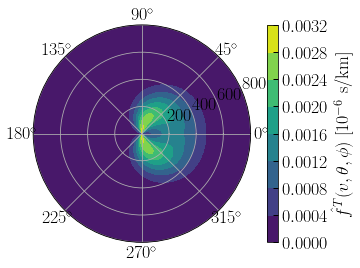

In [32]:
plt.figure()
ax = plt.subplot(111, projection='polar')

c = ax.contourf( theta_grid,v_grid, 1e6*MRT_grid)
ax.contourf(np.pi+theta_grid[::-1],v_grid, 1e6*MRT_grid) #Plot twice to get both sides of the polar plot...
#plt.xlabel(r'$v_\mathrm{min}$ [km/s]')
#plt.ylabel(r'$\theta/\pi$')
plt.colorbar(c,label=r'$\hat{f}^{T}(v,\theta,\phi)$ [$10^{-6}$ s/km]')
plt.show()

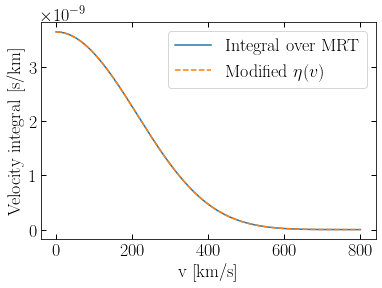

In [33]:
Mintegral = 2*np.pi*np.trapz(np.sin(theta_grid)*MRT_grid, theta_grid, axis=0)

plt.figure()

plt.plot(v_list, Mintegral/(2*np.pi), label='Integral over MRT')

plt.plot(v_list, DMU.calcMEta(v_list), linestyle='--', label='Modified $\eta(v)$')

plt.xlabel('v [km/s]')
plt.ylabel('Velocity integral [s/km]')

plt.legend()

plt.show()

### Directional rates

Here, we'll calculate some recoil distributions, as a function of $E_R$ and the angle between the recoil and the mean DM flux direction $\theta$. We'll consider a Xenon detector for concreteness.

In [34]:
N_p_Xe = 54
N_n_Xe = 77

m_x = 10 #GeV
sig = 1e-40 #cm^2

In [35]:
E_list = np.logspace(-1,1)
theta_list = np.linspace(0, np.pi)

E_grid, theta_grid = np.meshgrid(E_list, theta_list)

Rate_standard = DMU.dRdEdOmega_standard(E_grid, theta_grid, N_p_Xe, N_n_Xe, m_x, sig)

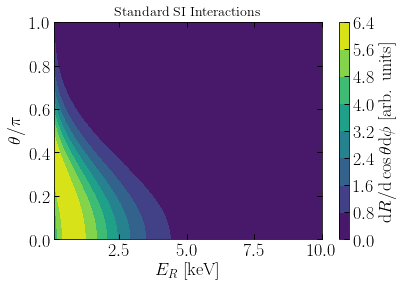

In [36]:
plt.figure()

plt.contourf(E_grid, theta_grid/np.pi, Rate_standard)

plt.xlabel(r'$E_R$ [keV]')
plt.ylabel(r'$\theta/\pi$')

plt.colorbar(label=r'$\mathrm{d}R/\mathrm{d}\cos\theta\mathrm{d}\phi$ [arb. units]')

plt.title("Standard SI Interactions",fontsize=14.0)

plt.show()

And now, some non-standard interaction. Let's try $\mathcal{O}_7$:

In [37]:
cp = np.zeros(20)
cn = np.zeros(20)

cp[6] = 1.0
cn[6] = 1.0

Rate_O7 = DMU.dRdEdOmega_NREFT(E_grid, theta_grid, m_x, cp, cn, "Xe131")

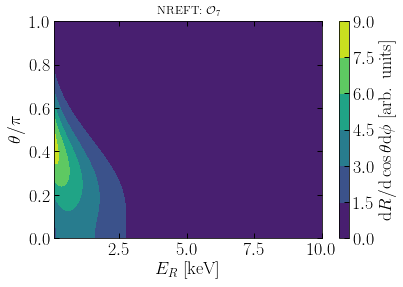

In [38]:
plt.figure()

plt.contourf(E_grid, theta_grid/np.pi, Rate_O7)

plt.xlabel(r'$E_R$ [keV]')
plt.ylabel(r'$\theta/\pi$')

plt.colorbar(label=r'$\mathrm{d}R/\mathrm{d}\cos\theta\mathrm{d}\phi$ [arb. units]')

plt.title("NREFT: $\mathcal{O}_7$",fontsize=12.0)

plt.show()

Now let's integrate over energies and calculate directional spectra (we'll also normalise 'per recoil'):

In [39]:
Dir_SI = np.trapz(Rate_standard, E_grid, axis=1)
Dir_SI /= np.trapz(np.sin(theta_list)*Dir_SI, theta_list)

Dir_O7 = np.trapz(Rate_O7, E_grid, axis=1)
Dir_O7 /= np.trapz(np.sin(theta_list)*Dir_O7, theta_list)

*Note that we're being careful about the distinction between $P(\cos\theta)$ and $P(\theta) = \sin\theta\, P(\cos\theta)$...*

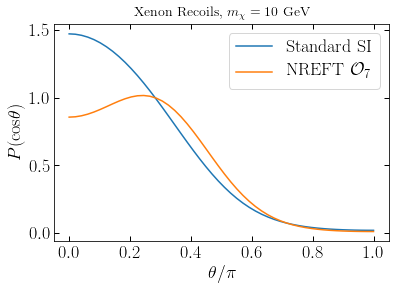

In [40]:
plt.figure()

plt.plot(theta_list/np.pi, Dir_SI, label="Standard SI")
plt.plot(theta_list/np.pi, Dir_O7, label="NREFT $\mathcal{O}_7$")

plt.legend()

plt.xlabel(r'$\theta/\pi$')
plt.ylabel(r'$P(\mathrm{cos}\theta)$')

plt.title("Xenon Recoils, $m_\chi = " + str(m_x) + " \,\,\mathrm{GeV}$",fontsize=14)

plt.show()

### Directional rates in lab coordinates

We can also calculate the rate as a function of ($\theta_l$ and $\phi_l$), which are angles as measured in a lab-fixed references frame, with $(N, W, Z)$ axes. $\theta_l = 0$ corresponds to recoils going directly upwards in the lab-frame. $\phi_l = 0$ corresponds to recoils pointed North (or possible South, depending on the signs of things...)

To do this calculation, we have to specify the location of the detector (we'll choose Amsterdam) and the time, we'll choose my birthday:

In [41]:
lat = 52 #degrees N
lon = 5 #degrees E

JD = DMU.JulianDay(3, 15, 1921, 6)

In [42]:
theta_lab_list = np.linspace(0, np.pi)
phi_lab_list = np.linspace(0,2*np.pi)

tlab_grid, plab_grid = np.meshgrid(theta_lab_list, phi_lab_list)

theta_vals = DMU.calcAngleFromMean(tlab_grid, plab_grid, lat=lat, lon=lon, JD=JD)

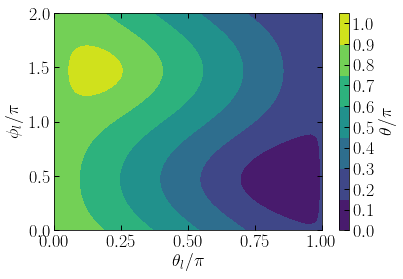

In [43]:
plt.figure()

plt.contourf(tlab_grid/np.pi, plab_grid/np.pi, theta_vals/np.pi)

plt.colorbar( label=r'$\theta/\pi$', ticks=np.linspace(0, 1,11))


plt.xlabel(r'$\theta_l/\pi$')
plt.ylabel(r'$\phi_l/\pi$')

plt.show()

Remember, $\theta$ measures the angle between the lab-fixed direction $(\theta_l, \phi_l)$ and the mean direction of the DM recoils (parallel to the mean DM flux).

At this particular time of day, the DM flux is roughly parallel to the direction $\theta_l \sim \pi$, so the mean recoil direction is pointing slightly off the vertical downwards direction.

By using $(\theta_l, \phi_l)$ we can specify the directions which would be measured by a detector (or, say, a rock) which is fixed in position on th Earth over a long period of time.

In [44]:
JD_list = DMU.JulianDay(3, 15, 1921, 6) + np.linspace(0, 1) #List of times over 1 day

In [45]:
#Directional spectrum (per recoil) in Xenon for SI interactions
Dir_SI_interp = interp1d(theta_list, Dir_SI)

Dir_grid_times = np.zeros((len(theta_lab_list), len(theta_lab_list), len(JD_list)))

#Calculate the directional spectrum at every time step
for i in range(len(JD_list)):
    Dir_grid_times[:,:,i] = Dir_SI_interp(DMU.calcAngleFromMean(tlab_grid, plab_grid, lat=lat, lon=lon, JD=JD_list[i]))
    
#Now integrate over times
Dir_grid = np.trapz(Dir_grid_times, JD_list, axis=-1)

So now, the distribution of recoils over the course of one day looks like this:

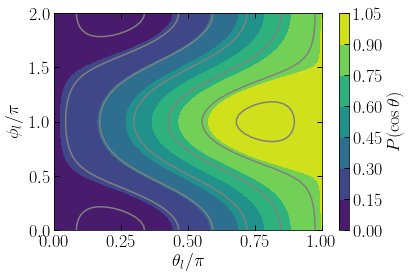

In [46]:
plt.figure()

plt.contourf(tlab_grid/np.pi, plab_grid/np.pi, Dir_grid)

plt.colorbar( label=r'$P(\cos\theta)$')

#The direction of the North-South rotation axis of the Earth,
# in (N,W,Z) lab-fixed coordinates.
v_NSaxis = [np.cos(lat*np.pi/180.0), 0, np.sin(lat*np.pi/180.0)]
dotprod = (np.sin(tlab_grid)*np.cos(plab_grid)*v_NSaxis[0]+ \
                np.sin(tlab_grid)*np.sin(plab_grid)*v_NSaxis[1] + \
                np.cos(tlab_grid)*v_NSaxis[2])
plt.contour(tlab_grid/np.pi, plab_grid/np.pi, np.arccos(dotprod), colors='grey')

plt.xlabel(r'$\theta_l/\pi$')
plt.ylabel(r'$\phi_l/\pi$')

plt.show()

The recoils appear mostly to be pointing downwards ($\theta_l = \pi$), because the DM flux comes mostly from overhead in the Northern hemisphere.

We've also added grey contours, which correspond to contours of constant angle, as measured (in the lab-fixed frame) from the direction of the North-South rotation axis of the Earth. As you can see, the recoil rate now depends *only* on this angle (because we've washed out any anisotropy along the perpendicular direction).

### Directionality in paleodetectors

The materials we're interested in are Zabuyelite (Zab) and Sylvanite (Syl):

In [47]:
# Zabuyelite is Li2CO3 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in lithium, carbon, and oxygen
# in that order
nuclei_Zab = ["Li", "C", "O"]
Zab_abun = np.array([0.189,0.162,0.649]) #Abundance fraction by mass
Zab_p = np.array([3,6,8]) #Number of protons
Zab_n = np.array([4,6,8]) #Number of neutrons

In [48]:
# Sylvanite is Au.75Ag.25Te2 therefore we need to some over several elements to get the signal
# Here we give the number of protons and neutrons in Gold, Silver, and Te
# in that order
nuclei_Syl = ["Au", "Ag", "Te"]
Syl_abun = np.array([0.343,0.0627,0.5936])
Syl_p = np.array([79,47,52])
Syl_n = np.array([118,61,76])

To get the signals, we need to sum the spectra for each element (DMU.dRdEdOmega_standard), weighting by the abundance.

Note that here we're still talking about the spectra in terms of recoil energies, whereas ultimately we'll want to talk about track lengths. The paleodetector git repo (https://github.com/tedwards2412/paleo_detectors) has code for translating between recoil energies and track lengths, but we're probably talking about being able to go down to a recoils of a few keV. 